## FFT Model demonstration
#### The following is a brief demonstration of the newly created FFT forecasting model. This model is especiall suited for data that is very seasonal. This is why I am using daily temperature data as an example input.

In [15]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import numpy as np


from u8timeseries import TimeSeries
from u8timeseries.models.fft import FFT
from u8timeseries.backtesting import simulate_forecast_ar

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Read data and fill gaps (you can safely ignore this part, it was not made to look nice)

In [16]:
# create series
df = pd.read_csv('temps.csv')
dates = df['Daily minimum temperatures'].str.replace('^[^\d]*', '').astype(float)
dates.index = pd.to_datetime(df['Date'])

# find missing dates
delta = pd.date_range(start = '1981-01-01', end = '1990-12-31' ).difference(dates.index)

# add missing dates
delta_vals = pd.Series([np.mean(dates)] * len(delta))
delta_vals.index = delta
dates = dates.append(delta_vals)
dates = dates.sort_index()

### Constructing our TimeSeries instance and a train and validation set

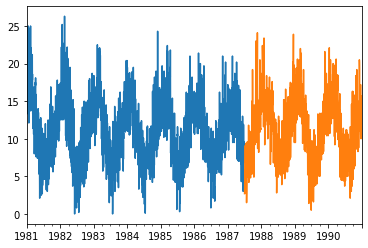

In [17]:
ts = TimeSeries.from_times_and_values(dates.index, dates)
train, val = ts.split_after(pd.Timestamp('19870701'))
train.plot()
val.plot()

### Default FFT model

In [18]:
model = FFT()
model.fit(train)
pred_val = model.predict(len(val))

[2020-04-24 17:21:42,714] INFO | u8timeseries.models.fft | fit function ran for 4 milliseconds


### Results:
#### The plot below shows us that a simple DFT with a random train-test split will most likely lead to bad results. Upon closer inspection we can see that the prediction (in green) simply repeats the training set (blue). This is the standard behavior of the DFT, and by itself it is quite useless, since repeating our training set could be done much more efficiently. However, two improvements were made to this approach.

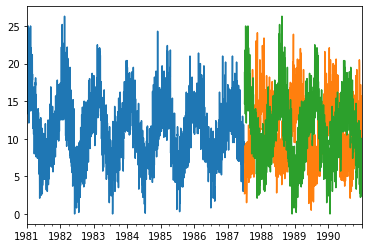

In [19]:
train.plot()
val.plot()
pred_val.plot()

### Improvement 1: Crop the training set
#### The first improvement that was implemented consists of cropping the training set before feeding it to the FFT algorithm such that the first timestamp in the cropped series matches the first timestamp to be predicted in terms of seasonality, i.e. it has to have the same month, day, weekday or time of day. We can achieve this by passing the optional argument 'required_matches' to the FFT constructor. In this case we want to the first timestamp in the training set to match the day of the month and the month of the year of the first predicted timestamp.

In [20]:
model = FFT(required_matches={'month', 'day'})
model.fit(train)
pred_val = model.predict(len(val))

[2020-04-24 17:21:44,059] INFO | u8timeseries.models.fft | fit function ran for 23 milliseconds


### Results:
#### We can see that the results are much better. However, this approach is still just an improved repetition of the training sequence, no FFT would be needed for this.

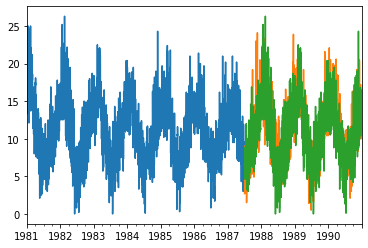

In [21]:
train.plot()
val.plot()
pred_val.plot()

### Improvement 2: Filtering out low-amplitude waves
#### The decomposition of the DFT into the frequency domain allows us to selectively filter out waves with low amplitudes. This allows us to keep strong seasonal trends while discarding some noise. This is achieved in the FFT model by passing the optional argument 'filter_percentile'. This argument represents the percentage of the frequencies that will be discarded. For instance, if a value of 95 is passed, only the 5% strongest frequencies will be kept.

In [22]:
model = FFT(required_matches={'month', 'day'}, filter_percentile=95)
model.fit(train)
pred_val = model.predict(len(val))

[2020-04-24 17:21:45,223] INFO | u8timeseries.models.fft | fit function ran for 23 milliseconds


### Results:
#### We get a signal that is less noisy. Depending on the data set, this might be a better forecast. In this case, however, this filtering might have been too much.

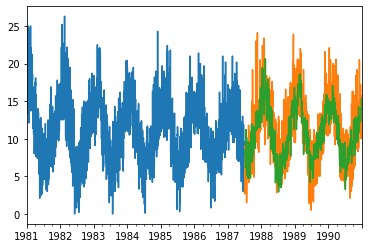

In [23]:
train.plot()
val.plot()
pred_val.plot()

#### We can also see that the model performs quite well when evaluated with the simulate_forecast_ar function as well.

In [13]:
historical_fcast = simulate_forecast_ar(ts, model, pd.Timestamp('19870105'), fcast_horizon_n=10, verbose=True)

[2020-04-24 17:20:07,735] INFO | u8timeseries.models.fft | fit function ran for 11 milliseconds
[2020-04-24 17:20:07,780] INFO | u8timeseries.models.fft | fit function ran for 8 milliseconds
[2020-04-24 17:20:07,810] INFO | u8timeseries.models.fft | fit function ran for 10 milliseconds
[2020-04-24 17:20:07,831] INFO | u8timeseries.models.fft | fit function ran for 4 milliseconds
[2020-04-24 17:20:07,847] INFO | u8timeseries.models.fft | fit function ran for 4 milliseconds
[2020-04-24 17:20:07,868] INFO | u8timeseries.models.fft | fit function ran for 5 milliseconds
[2020-04-24 17:20:07,887] INFO | u8timeseries.models.fft | fit function ran for 6 milliseconds
[2020-04-24 17:20:07,912] INFO | u8timeseries.models.fft | fit function ran for 7 milliseconds
[2020-04-24 17:20:07,931] INFO | u8timeseries.models.fft | fit function ran for 4 milliseconds
[2020-04-24 17:20:07,952] INFO | u8timeseries.models.fft | fit function ran for 6 milliseconds
[2020-04-24 17:20:07,972] INFO | u8timeseries.mo

[2020-04-24 17:20:10,055] INFO | u8timeseries.models.fft | fit function ran for 13 milliseconds
[2020-04-24 17:20:10,087] INFO | u8timeseries.models.fft | fit function ran for 16 milliseconds
[2020-04-24 17:20:10,123] INFO | u8timeseries.models.fft | fit function ran for 14 milliseconds
[2020-04-24 17:20:10,151] INFO | u8timeseries.models.fft | fit function ran for 14 milliseconds
[2020-04-24 17:20:10,180] INFO | u8timeseries.models.fft | fit function ran for 13 milliseconds
[2020-04-24 17:20:10,211] INFO | u8timeseries.models.fft | fit function ran for 15 milliseconds
[2020-04-24 17:20:10,240] INFO | u8timeseries.models.fft | fit function ran for 14 milliseconds
[2020-04-24 17:20:10,268] INFO | u8timeseries.models.fft | fit function ran for 14 milliseconds
[2020-04-24 17:20:10,298] INFO | u8timeseries.models.fft | fit function ran for 13 milliseconds
[2020-04-24 17:20:10,329] INFO | u8timeseries.models.fft | fit function ran for 16 milliseconds
[2020-04-24 17:20:10,357] INFO | u8times

[2020-04-24 17:20:12,932] INFO | u8timeseries.models.fft | fit function ran for 25 milliseconds
[2020-04-24 17:20:12,978] INFO | u8timeseries.models.fft | fit function ran for 30 milliseconds
[2020-04-24 17:20:13,018] INFO | u8timeseries.models.fft | fit function ran for 24 milliseconds
[2020-04-24 17:20:13,059] INFO | u8timeseries.models.fft | fit function ran for 25 milliseconds
[2020-04-24 17:20:13,104] INFO | u8timeseries.models.fft | fit function ran for 27 milliseconds
[2020-04-24 17:20:13,145] INFO | u8timeseries.models.fft | fit function ran for 26 milliseconds
[2020-04-24 17:20:13,182] INFO | u8timeseries.models.fft | fit function ran for 23 milliseconds
[2020-04-24 17:20:13,224] INFO | u8timeseries.models.fft | fit function ran for 26 milliseconds
[2020-04-24 17:20:13,261] INFO | u8timeseries.models.fft | fit function ran for 23 milliseconds
[2020-04-24 17:20:13,298] INFO | u8timeseries.models.fft | fit function ran for 23 milliseconds
[2020-04-24 17:20:13,348] INFO | u8times

[2020-04-24 17:20:16,615] INFO | u8timeseries.models.fft | fit function ran for 29 milliseconds
[2020-04-24 17:20:16,659] INFO | u8timeseries.models.fft | fit function ran for 31 milliseconds
[2020-04-24 17:20:16,708] INFO | u8timeseries.models.fft | fit function ran for 31 milliseconds
[2020-04-24 17:20:16,750] INFO | u8timeseries.models.fft | fit function ran for 29 milliseconds
[2020-04-24 17:20:16,792] INFO | u8timeseries.models.fft | fit function ran for 31 milliseconds
[2020-04-24 17:20:16,839] INFO | u8timeseries.models.fft | fit function ran for 32 milliseconds
[2020-04-24 17:20:16,884] INFO | u8timeseries.models.fft | fit function ran for 31 milliseconds
[2020-04-24 17:20:16,927] INFO | u8timeseries.models.fft | fit function ran for 31 milliseconds
[2020-04-24 17:20:16,973] INFO | u8timeseries.models.fft | fit function ran for 31 milliseconds
[2020-04-24 17:20:17,017] INFO | u8timeseries.models.fft | fit function ran for 31 milliseconds
[2020-04-24 17:20:17,059] INFO | u8times

[2020-04-24 17:20:21,289] INFO | u8timeseries.models.fft | fit function ran for 40 milliseconds
[2020-04-24 17:20:21,347] INFO | u8timeseries.models.fft | fit function ran for 42 milliseconds
[2020-04-24 17:20:21,402] INFO | u8timeseries.models.fft | fit function ran for 41 milliseconds
[2020-04-24 17:20:21,464] INFO | u8timeseries.models.fft | fit function ran for 43 milliseconds
[2020-04-24 17:20:21,517] INFO | u8timeseries.models.fft | fit function ran for 39 milliseconds
[2020-04-24 17:20:21,579] INFO | u8timeseries.models.fft | fit function ran for 44 milliseconds
[2020-04-24 17:20:21,631] INFO | u8timeseries.models.fft | fit function ran for 39 milliseconds
[2020-04-24 17:20:21,687] INFO | u8timeseries.models.fft | fit function ran for 41 milliseconds
[2020-04-24 17:20:21,744] INFO | u8timeseries.models.fft | fit function ran for 40 milliseconds
[2020-04-24 17:20:21,801] INFO | u8timeseries.models.fft | fit function ran for 43 milliseconds
[2020-04-24 17:20:21,866] INFO | u8times

[2020-04-24 17:20:24,380] INFO | u8timeseries.models.fft | fit function ran for 15 milliseconds
[2020-04-24 17:20:24,422] INFO | u8timeseries.models.fft | fit function ran for 15 milliseconds
[2020-04-24 17:20:24,461] INFO | u8timeseries.models.fft | fit function ran for 14 milliseconds
[2020-04-24 17:20:24,493] INFO | u8timeseries.models.fft | fit function ran for 14 milliseconds
[2020-04-24 17:20:24,530] INFO | u8timeseries.models.fft | fit function ran for 15 milliseconds
[2020-04-24 17:20:24,561] INFO | u8timeseries.models.fft | fit function ran for 14 milliseconds
[2020-04-24 17:20:24,591] INFO | u8timeseries.models.fft | fit function ran for 12 milliseconds
[2020-04-24 17:20:24,621] INFO | u8timeseries.models.fft | fit function ran for 13 milliseconds
[2020-04-24 17:20:24,659] INFO | u8timeseries.models.fft | fit function ran for 14 milliseconds
[2020-04-24 17:20:24,688] INFO | u8timeseries.models.fft | fit function ran for 13 milliseconds
[2020-04-24 17:20:24,718] INFO | u8times

[2020-04-24 17:20:27,688] INFO | u8timeseries.models.fft | fit function ran for 19 milliseconds
[2020-04-24 17:20:27,727] INFO | u8timeseries.models.fft | fit function ran for 20 milliseconds
[2020-04-24 17:20:27,762] INFO | u8timeseries.models.fft | fit function ran for 21 milliseconds
[2020-04-24 17:20:27,797] INFO | u8timeseries.models.fft | fit function ran for 19 milliseconds
[2020-04-24 17:20:27,834] INFO | u8timeseries.models.fft | fit function ran for 21 milliseconds
[2020-04-24 17:20:27,867] INFO | u8timeseries.models.fft | fit function ran for 19 milliseconds
[2020-04-24 17:20:27,901] INFO | u8timeseries.models.fft | fit function ran for 19 milliseconds
[2020-04-24 17:20:27,940] INFO | u8timeseries.models.fft | fit function ran for 23 milliseconds
[2020-04-24 17:20:27,978] INFO | u8timeseries.models.fft | fit function ran for 19 milliseconds
[2020-04-24 17:20:28,012] INFO | u8timeseries.models.fft | fit function ran for 19 milliseconds
[2020-04-24 17:20:28,055] INFO | u8times

[2020-04-24 17:20:31,228] INFO | u8timeseries.models.fft | fit function ran for 27 milliseconds
[2020-04-24 17:20:31,269] INFO | u8timeseries.models.fft | fit function ran for 27 milliseconds
[2020-04-24 17:20:31,323] INFO | u8timeseries.models.fft | fit function ran for 38 milliseconds
[2020-04-24 17:20:31,378] INFO | u8timeseries.models.fft | fit function ran for 32 milliseconds
[2020-04-24 17:20:31,432] INFO | u8timeseries.models.fft | fit function ran for 32 milliseconds
[2020-04-24 17:20:31,478] INFO | u8timeseries.models.fft | fit function ran for 30 milliseconds
[2020-04-24 17:20:31,521] INFO | u8timeseries.models.fft | fit function ran for 28 milliseconds
[2020-04-24 17:20:31,567] INFO | u8timeseries.models.fft | fit function ran for 29 milliseconds
[2020-04-24 17:20:31,614] INFO | u8timeseries.models.fft | fit function ran for 29 milliseconds
[2020-04-24 17:20:31,660] INFO | u8timeseries.models.fft | fit function ran for 31 milliseconds
[2020-04-24 17:20:31,728] INFO | u8times

[2020-04-24 17:20:35,666] INFO | u8timeseries.models.fft | fit function ran for 36 milliseconds
[2020-04-24 17:20:35,715] INFO | u8timeseries.models.fft | fit function ran for 35 milliseconds
[2020-04-24 17:20:35,773] INFO | u8timeseries.models.fft | fit function ran for 41 milliseconds
[2020-04-24 17:20:35,830] INFO | u8timeseries.models.fft | fit function ran for 42 milliseconds
[2020-04-24 17:20:35,887] INFO | u8timeseries.models.fft | fit function ran for 37 milliseconds
[2020-04-24 17:20:35,937] INFO | u8timeseries.models.fft | fit function ran for 36 milliseconds
[2020-04-24 17:20:35,992] INFO | u8timeseries.models.fft | fit function ran for 39 milliseconds
[2020-04-24 17:20:36,046] INFO | u8timeseries.models.fft | fit function ran for 39 milliseconds
[2020-04-24 17:20:36,102] INFO | u8timeseries.models.fft | fit function ran for 38 milliseconds
[2020-04-24 17:20:36,154] INFO | u8timeseries.models.fft | fit function ran for 37 milliseconds
[2020-04-24 17:20:36,210] INFO | u8times

[2020-04-24 17:20:39,058] INFO | u8timeseries.models.fft | fit function ran for 12 milliseconds
[2020-04-24 17:20:39,091] INFO | u8timeseries.models.fft | fit function ran for 10 milliseconds
[2020-04-24 17:20:39,135] INFO | u8timeseries.models.fft | fit function ran for 13 milliseconds
[2020-04-24 17:20:39,166] INFO | u8timeseries.models.fft | fit function ran for 12 milliseconds
[2020-04-24 17:20:39,198] INFO | u8timeseries.models.fft | fit function ran for 13 milliseconds
[2020-04-24 17:20:39,225] INFO | u8timeseries.models.fft | fit function ran for 10 milliseconds
[2020-04-24 17:20:39,257] INFO | u8timeseries.models.fft | fit function ran for 11 milliseconds
[2020-04-24 17:20:39,284] INFO | u8timeseries.models.fft | fit function ran for 10 milliseconds
[2020-04-24 17:20:39,311] INFO | u8timeseries.models.fft | fit function ran for 10 milliseconds
[2020-04-24 17:20:39,345] INFO | u8timeseries.models.fft | fit function ran for 13 milliseconds
[2020-04-24 17:20:39,385] INFO | u8times

[2020-04-24 17:20:41,869] INFO | u8timeseries.models.fft | fit function ran for 18 milliseconds
[2020-04-24 17:20:41,908] INFO | u8timeseries.models.fft | fit function ran for 18 milliseconds
[2020-04-24 17:20:41,940] INFO | u8timeseries.models.fft | fit function ran for 17 milliseconds
[2020-04-24 17:20:41,978] INFO | u8timeseries.models.fft | fit function ran for 20 milliseconds
[2020-04-24 17:20:42,010] INFO | u8timeseries.models.fft | fit function ran for 17 milliseconds
[2020-04-24 17:20:42,043] INFO | u8timeseries.models.fft | fit function ran for 17 milliseconds
[2020-04-24 17:20:42,079] INFO | u8timeseries.models.fft | fit function ran for 19 milliseconds
[2020-04-24 17:20:42,112] INFO | u8timeseries.models.fft | fit function ran for 17 milliseconds
[2020-04-24 17:20:42,143] INFO | u8timeseries.models.fft | fit function ran for 17 milliseconds
[2020-04-24 17:20:42,180] INFO | u8timeseries.models.fft | fit function ran for 18 milliseconds
[2020-04-24 17:20:42,213] INFO | u8times

[2020-04-24 17:20:45,160] INFO | u8timeseries.models.fft | fit function ran for 25 milliseconds
[2020-04-24 17:20:45,205] INFO | u8timeseries.models.fft | fit function ran for 27 milliseconds
[2020-04-24 17:20:45,245] INFO | u8timeseries.models.fft | fit function ran for 26 milliseconds
[2020-04-24 17:20:45,285] INFO | u8timeseries.models.fft | fit function ran for 25 milliseconds
[2020-04-24 17:20:45,332] INFO | u8timeseries.models.fft | fit function ran for 29 milliseconds
[2020-04-24 17:20:45,373] INFO | u8timeseries.models.fft | fit function ran for 27 milliseconds
[2020-04-24 17:20:45,422] INFO | u8timeseries.models.fft | fit function ran for 30 milliseconds
[2020-04-24 17:20:45,467] INFO | u8timeseries.models.fft | fit function ran for 28 milliseconds
[2020-04-24 17:20:45,508] INFO | u8timeseries.models.fft | fit function ran for 25 milliseconds
[2020-04-24 17:20:45,550] INFO | u8timeseries.models.fft | fit function ran for 27 milliseconds
[2020-04-24 17:20:45,596] INFO | u8times

[2020-04-24 17:20:49,171] INFO | u8timeseries.models.fft | fit function ran for 33 milliseconds
[2020-04-24 17:20:49,219] INFO | u8timeseries.models.fft | fit function ran for 33 milliseconds
[2020-04-24 17:20:49,272] INFO | u8timeseries.models.fft | fit function ran for 36 milliseconds
[2020-04-24 17:20:49,320] INFO | u8timeseries.models.fft | fit function ran for 33 milliseconds
[2020-04-24 17:20:49,378] INFO | u8timeseries.models.fft | fit function ran for 39 milliseconds
[2020-04-24 17:20:49,430] INFO | u8timeseries.models.fft | fit function ran for 36 milliseconds
[2020-04-24 17:20:49,483] INFO | u8timeseries.models.fft | fit function ran for 36 milliseconds
[2020-04-24 17:20:49,532] INFO | u8timeseries.models.fft | fit function ran for 34 milliseconds
[2020-04-24 17:20:49,586] INFO | u8timeseries.models.fft | fit function ran for 37 milliseconds
[2020-04-24 17:20:49,635] INFO | u8timeseries.models.fft | fit function ran for 34 milliseconds
[2020-04-24 17:20:49,689] INFO | u8times

[2020-04-24 17:20:53,543] INFO | u8timeseries.models.fft | fit function ran for 8 milliseconds
[2020-04-24 17:20:53,567] INFO | u8timeseries.models.fft | fit function ran for 7 milliseconds
[2020-04-24 17:20:53,590] INFO | u8timeseries.models.fft | fit function ran for 6 milliseconds
[2020-04-24 17:20:53,613] INFO | u8timeseries.models.fft | fit function ran for 7 milliseconds
[2020-04-24 17:20:53,637] INFO | u8timeseries.models.fft | fit function ran for 6 milliseconds
[2020-04-24 17:20:53,669] INFO | u8timeseries.models.fft | fit function ran for 10 milliseconds
[2020-04-24 17:20:53,693] INFO | u8timeseries.models.fft | fit function ran for 6 milliseconds
[2020-04-24 17:20:53,718] INFO | u8timeseries.models.fft | fit function ran for 8 milliseconds
[2020-04-24 17:20:53,743] INFO | u8timeseries.models.fft | fit function ran for 7 milliseconds
[2020-04-24 17:20:53,772] INFO | u8timeseries.models.fft | fit function ran for 7 milliseconds
[2020-04-24 17:20:53,796] INFO | u8timeseries.mod

[2020-04-24 17:20:56,254] INFO | u8timeseries.models.fft | fit function ran for 16 milliseconds
[2020-04-24 17:20:56,285] INFO | u8timeseries.models.fft | fit function ran for 17 milliseconds
[2020-04-24 17:20:56,330] INFO | u8timeseries.models.fft | fit function ran for 22 milliseconds
[2020-04-24 17:20:56,366] INFO | u8timeseries.models.fft | fit function ran for 19 milliseconds
[2020-04-24 17:20:56,401] INFO | u8timeseries.models.fft | fit function ran for 18 milliseconds
[2020-04-24 17:20:56,443] INFO | u8timeseries.models.fft | fit function ran for 23 milliseconds
[2020-04-24 17:20:56,480] INFO | u8timeseries.models.fft | fit function ran for 20 milliseconds
[2020-04-24 17:20:56,515] INFO | u8timeseries.models.fft | fit function ran for 18 milliseconds
[2020-04-24 17:20:56,551] INFO | u8timeseries.models.fft | fit function ran for 18 milliseconds
[2020-04-24 17:20:56,588] INFO | u8timeseries.models.fft | fit function ran for 20 milliseconds
[2020-04-24 17:20:56,625] INFO | u8times

[2020-04-24 17:20:59,609] INFO | u8timeseries.models.fft | fit function ran for 26 milliseconds
[2020-04-24 17:20:59,649] INFO | u8timeseries.models.fft | fit function ran for 24 milliseconds
[2020-04-24 17:20:59,688] INFO | u8timeseries.models.fft | fit function ran for 23 milliseconds
[2020-04-24 17:20:59,732] INFO | u8timeseries.models.fft | fit function ran for 27 milliseconds
[2020-04-24 17:20:59,773] INFO | u8timeseries.models.fft | fit function ran for 24 milliseconds
[2020-04-24 17:20:59,812] INFO | u8timeseries.models.fft | fit function ran for 24 milliseconds
[2020-04-24 17:20:59,859] INFO | u8timeseries.models.fft | fit function ran for 28 milliseconds
[2020-04-24 17:20:59,900] INFO | u8timeseries.models.fft | fit function ran for 26 milliseconds
[2020-04-24 17:20:59,940] INFO | u8timeseries.models.fft | fit function ran for 25 milliseconds
[2020-04-24 17:20:59,985] INFO | u8timeseries.models.fft | fit function ran for 26 milliseconds
[2020-04-24 17:21:00,028] INFO | u8times

[2020-04-24 17:21:03,570] INFO | u8timeseries.models.fft | fit function ran for 33 milliseconds
[2020-04-24 17:21:03,625] INFO | u8timeseries.models.fft | fit function ran for 38 milliseconds
[2020-04-24 17:21:03,674] INFO | u8timeseries.models.fft | fit function ran for 33 milliseconds
[2020-04-24 17:21:03,723] INFO | u8timeseries.models.fft | fit function ran for 33 milliseconds
[2020-04-24 17:21:03,776] INFO | u8timeseries.models.fft | fit function ran for 35 milliseconds
[2020-04-24 17:21:03,825] INFO | u8timeseries.models.fft | fit function ran for 34 milliseconds
[2020-04-24 17:21:03,874] INFO | u8timeseries.models.fft | fit function ran for 32 milliseconds
[2020-04-24 17:21:03,929] INFO | u8timeseries.models.fft | fit function ran for 37 milliseconds
[2020-04-24 17:21:03,978] INFO | u8timeseries.models.fft | fit function ran for 33 milliseconds
[2020-04-24 17:21:04,036] INFO | u8timeseries.models.fft | fit function ran for 38 milliseconds
[2020-04-24 17:21:04,086] INFO | u8times

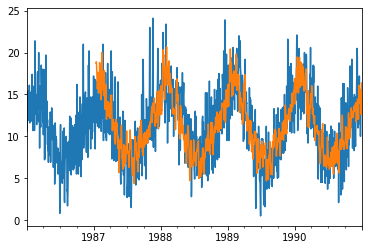

In [14]:
ts.drop_before(pd.Timestamp('1986')).plot()


historical_fcast.plot()
